# Check samples
We created a bunch of samples with PSM, now I need to check to see if they are good for anything

In [46]:
# Imports
import os
import numpy as np
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [13]:
# Paths
abide_ref_path = '/data1/abide/Pheno/psm/abide_qc_maybe.csv'

abide_full_maybe = '/data1/abide/Pheno/psm/abide_full_maybe.csv'
abide_ados_maybe = '/data1/abide/Pheno/psm/abide_ados_maybe.csv'
abide_srs_maybe = '/data1/abide/Pheno/psm/abide_srs_maybe.csv'
abide_fiq_maybe = '/data1/abide/Pheno/psm/abide_fiq_maybe.csv'

abide_full_pass = '/data1/abide/Pheno/psm/abide_full_pass.csv'
abide_ados_pass = '/data1/abide/Pheno/psm/abide_ados_pass.csv'
abide_srs_pass = '/data1/abide/Pheno/psm/abide_srs_pass.csv'
abide_fiq_pass = '/data1/abide/Pheno/psm/abide_fiq_pass.csv'

Ok, let's test this for one pheno variable and then make it dynamic

In [14]:
abide_ref = pd.read_csv(abide_ref_path)

In [84]:
use_pheno = abide_srs_pass

In [85]:
pheno = pd.read_csv(use_pheno)
# Get just the subject ID, the distance and the weights
pheno = pheno[['SUB_ID', 'distance', 'weights']]
# Merge the two dataframes
merged = pd.merge(abide_ref, pheno, on='SUB_ID', how='inner')

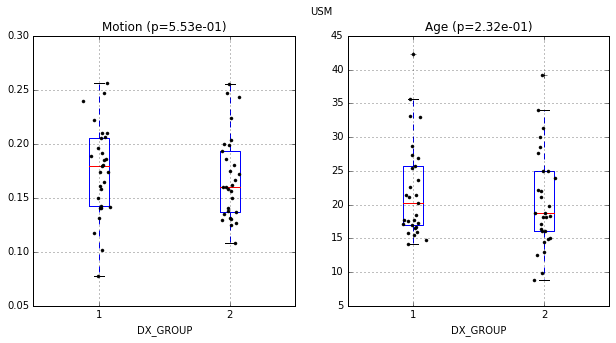

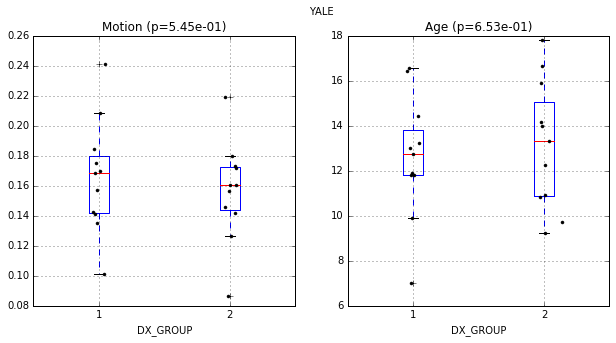

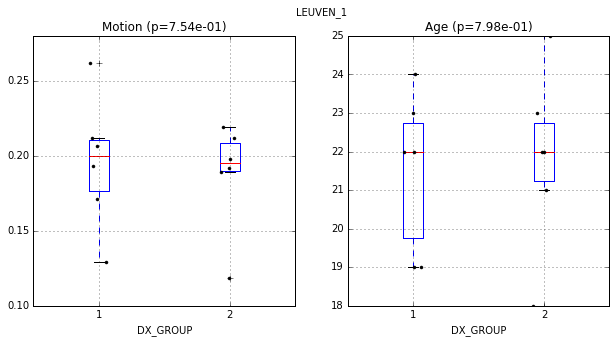

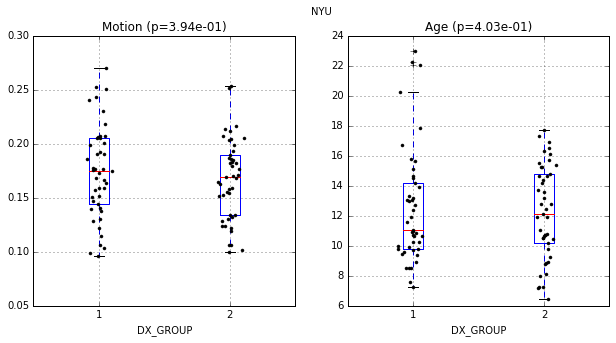

In [86]:
# Go through the sites
for site in list(merged.SITE_ID.unique()):
    tmp = merged[merged.SITE_ID==site]

    f = plt.figure(figsize=(10,5))
    ax_mot = f.add_subplot(121)
    ax_age = f.add_subplot(122)
    tmp.boxplot('AGE_AT_SCAN', by='DX_GROUP', ax=ax_age)
    tmp.boxplot('FD_scrubbed', by='DX_GROUP', ax=ax_mot)

    # Add the point stuff
    for i, x in tmp.groupby('DX_GROUP'):
        # Motion
        y_mot = x['FD_scrubbed'].values
        x_mot = np.random.normal(i, 0.04, len(y_mot))
        ax_mot.plot(x_mot, y_mot, '.k')

        # Age
        y_age = x['AGE_AT_SCAN'].values
        x_age = np.random.normal(i, 0.04, len(y_age))
        ax_age.plot(x_age, y_age, '.k')

    # Compute the p-value for the difference
    age = [x['AGE_AT_SCAN'].values for i, x in tmp.groupby('DX_GROUP')]
    age_pat = np.array(age[0])
    age_ctr = np.array(age[1])
    mot = [x['FD_scrubbed'].values for i, x in tmp.groupby('DX_GROUP')]
    mot_pat = np.array(mot[0])
    mot_ctr = np.array(mot[1])

    # Motion
    if st.shapiro(mot_pat)[1]<0.01 or st.shapiro(mot_ctr)[1]<0.01:
        # Not normal, MannWhitney
        test_mot = st.mannwhitneyu(mot_pat, mot_ctr)
    else:
        # Normal, check variance
        if st.levene(mot_pat, mot_ctr)[1]<0.01:
            # Not same variance
            test_mot = st.ttest_ind(mot_pat, mot_ctr, equal_var=False)
        else:
            # Same variance
            test_mot = st.ttest_ind(mot_pat, mot_ctr, equal_var=True)

    # Age
    if st.shapiro(age_pat)[1]<0.01 or st.shapiro(age_ctr)[1]<0.01:
        # Not normal, MannWhitney
        test_age = st.mannwhitneyu(age_pat, age_ctr)
    else:
        # Normal, check variance
        if st.levene(age_pat, age_ctr)[1]<0.01:
            # Not same variance
            test_age = st.ttest_ind(age_pat, age_ctr, equal_var=False)
        else:
            # Same variance
            test_age = st.ttest_ind(age_pat, age_ctr, equal_var=True)

    # Put that in the axis title
    ax_mot.set_title('Motion (p={:.2e})'.format(test_mot[1]))
    ax_age.set_title('Age (p={:.2e})'.format(test_age[1]))

    if test_age[1] < 0.01 or test_mot[1] < 0.01:
        f.suptitle('{} (SIG)'.format(site))
    else:
        f.suptitle('{}'.format(site))